<a href="https://colab.research.google.com/github/Chenghao-WEI/PINN-CAVITY/blob/main/PINN_cavity_steady_streamfunction_final_dynamics_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import autograd
from torch import nn
from torch.utils.data import DataLoader
#from torchvision import datasets
#from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from itertools import product
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.11.0
True
11.3


神经网络构建

In [3]:
class PINN(nn.Module):
    def __init__(self, NL, NN):
        super(PINN, self).__init__() 
        self.dense = nn.Sequential()
        self.dense.add_module("input",nn.Linear(2, NN))
        self.dense.add_module("input_act",nn.Tanh())
        for i in range(NL):
            self.dense.add_module("hidden"+str(i),nn.Linear(NN, NN))
            self.dense.add_module("hidden_act"+str(i),nn.Tanh())
        self.dense.add_module("output",nn.Linear(NN, 2))
        
        for p in self.modules():
            if isinstance(p, nn.Conv2d):
                nn.init.xavier_normal(p.weight.data)
            elif isinstance(p, nn.Linear):
                nn.init.xavier_uniform_(p.weight.data, gain=1.0)
                
        

    def forward(self,x):
        out_final = self.dense(x)
        return out_final


In [4]:
net=PINN(7,50) 
print(net)

PINN(
  (dense): Sequential(
    (input): Linear(in_features=2, out_features=50, bias=True)
    (input_act): Tanh()
    (hidden0): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act0): Tanh()
    (hidden1): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act1): Tanh()
    (hidden2): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act2): Tanh()
    (hidden3): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act3): Tanh()
    (hidden4): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act4): Tanh()
    (hidden5): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act5): Tanh()
    (hidden6): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act6): Tanh()
    (output): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [5]:

mse_cost_function = torch.nn.MSELoss(reduction='mean') # Mean squared error 均方误差求
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)  # 优化器
#optimizer =torch.optim.LBFGS(net.parameters(), lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

PINN(
  (dense): Sequential(
    (input): Linear(in_features=2, out_features=50, bias=True)
    (input_act): Tanh()
    (hidden0): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act0): Tanh()
    (hidden1): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act1): Tanh()
    (hidden2): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act2): Tanh()
    (hidden3): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act3): Tanh()
    (hidden4): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act4): Tanh()
    (hidden5): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act5): Tanh()
    (hidden6): Linear(in_features=50, out_features=50, bias=True)
    (hidden_act6): Tanh()
    (output): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [7]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [8]:
class Navier_Stokes2D:
    def __init__(self, operator, bcs_sampler, res_sampler, Re):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_y, self.sigma_y = self.mu_X[1], self.sigma_X[1]

        self.Re = Re

        # Samplers
        self.operator = operator
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Logger
        self.loss_res_log = []
        self.loss_bcs_log = []

        #
        self.beta = 0.9
        self.adaptive_constant_bcs_val = 1.0



    #Forward for stream-presssure formulation
    def psi_p(self, xy):
        pt_xy = Variable(torch.from_numpy(xy).float(), requires_grad=True).to(device)
        uvp = net(pt_xy)
        psi = uvp[:,0].unsqueeze(-1)
        p = uvp[:,1].unsqueeze(-1)
        return psi, p

    #Forward for velocities
    def uv(self,xy):
        pt_xy = Variable(torch.from_numpy(xy).float(), requires_grad=True).to(device)
        uvp = net(pt_xy)
        psi = uvp[:,0].unsqueeze(-1)
        u = autograd.grad(psi, pt_xy, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:,1].unsqueeze(-1)/self.sigma_y # u = dpsi/dy
        v = -autograd.grad(psi, pt_xy, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:,0].unsqueeze(-1)/self.sigma_x # u = dpsi/dx
        return u, v

    #Forward for residuals
    def res(self, xy):
        res_u_pred, res_v_pred = self.operator(xy, self.Re, self.sigma_x, self.sigma_y)
        return res_u_pred, res_v_pred


    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y


    def train(self, nIter=10000, batch_size=128):

        for it in range(nIter):
            optimizer.zero_grad()
            # Fetch boundary mini-batches
            X_bc1_batch, uv_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, uv_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, uv_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            X_bc4_batch, uv_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

            # Fetch residual mini-batch
            X_res_batch, mom_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

            # Boundary predictions
            u_bc1_pred, v_bc1_pred = self.uv(X_bc1_batch)
            u_bc2_pred, v_bc2_pred = self.uv(X_bc2_batch)
            u_bc3_pred, v_bc3_pred = self.uv(X_bc3_batch)
            u_bc4_pred, v_bc4_pred = self.uv(X_bc4_batch)

            uv_bc1_pred = torch.cat([u_bc1_pred, v_bc1_pred], 1)
            uv_bc2_pred = torch.cat([u_bc2_pred, v_bc2_pred], 1)
            uv_bc3_pred = torch.cat([u_bc3_pred, v_bc3_pred], 1)
            uv_bc4_pred = torch.cat([u_bc4_pred, v_bc4_pred], 1)

            #Boundary loss
            pt_uv_bc1_batch = Variable(torch.from_numpy(uv_bc1_batch).float(), requires_grad=True).to(device)
            pt_uv_bc2_batch = Variable(torch.from_numpy(uv_bc2_batch).float(), requires_grad=True).to(device)
            pt_uv_bc3_batch = Variable(torch.from_numpy(uv_bc3_batch).float(), requires_grad=True).to(device)
            pt_uv_bc4_batch = Variable(torch.from_numpy(uv_bc4_batch).float(), requires_grad=True).to(device)

            loss_bc1 = torch.mean(torch.square(uv_bc1_pred-pt_uv_bc1_batch))
            loss_bc2 = torch.mean(torch.square(uv_bc2_pred))
            loss_bc3 = torch.mean(torch.square(uv_bc3_pred))
            loss_bc4 = torch.mean(torch.square(uv_bc4_pred))
            
            loss_bcs = torch.mean(loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4)
            
            #Residual loss
            u_momentum_pred, v_momentum_pred = self.res(X_res_batch)
            pt_mom_res_batch = Variable(torch.from_numpy(mom_res_batch).float(), requires_grad=True).to(device)
            mom_res_pred = torch.cat([u_momentum_pred, v_momentum_pred], 1)
            loss_res = torch.mean(torch.square(u_momentum_pred)) + torch.mean(torch.square(v_momentum_pred))


            
            #adaptive constant update
            if it % 10 == 0:
                grad_max_bcs_list = []
                grad_mean_bcs_list = []
                grad_max_res_list = []
                grad_mean_res_list = []
                loss_res.backward(retain_graph=True)
                for name, grad_res in net.named_parameters():
                    if "weight" in name:
                        grad_max_res_list.append(torch.max(torch.abs(grad_res)))
                        grad_mean_res_list.append(torch.mean(torch.abs(grad_res)))
                grad_max_res = torch.max(torch.stack(grad_max_res_list))
                grad_mean_res = torch.mean(torch.stack(grad_mean_res_list))
                optimizer.zero_grad()

                loss_bcs.backward(retain_graph=True)
                for name, grad_bcs in net.named_parameters():
                    if "weight" in name:
                        grad_max_bcs_list.append(torch.max(torch.abs(grad_bcs)))
                        grad_mean_bcs_list.append(torch.mean(torch.abs(grad_bcs)))
                grad_max_bcs = torch.max(torch.stack(grad_max_bcs_list))
                grad_mean_bcs = torch.mean(torch.stack(grad_mean_bcs_list))
                optimizer.zero_grad()

                adaptive_constant_bcs_hat = grad_max_res / grad_mean_bcs
                self.adaptive_constant_bcs_val = adaptive_constant_bcs_hat * (1.0-self.beta) + self.beta * self.adaptive_constant_bcs_val
     
            #Total loss
            loss = loss_res +  self.adaptive_constant_bcs_val.data * loss_bcs

            loss.backward()
            optimizer.step()



            # Print
            if it % 10 == 0:
                loss_value = loss
                loss_u_value = loss_bcs
                loss_r_value = loss_res

                self.loss_bcs_log.append(loss_u_value)
                self.loss_res_log.append(loss_r_value)

                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, constant_bc_val: %.3e' %
                      (it, loss_value, loss_u_value, loss_r_value, self.adaptive_constant_bcs_val))

                

            #for name, parameters in net.state_dict().items():
             #   if "weight" in name:
              #      print(parameters)
               #     #loss_res_var = Variable(loss_res,requires_grad=True).to(device)
                #    grad_res = autograd.backward(loss_res)[0]#[:,1].unsqueeze(-1)
            #print(loss_res)

    # Evaluate predictions ar test points
    def predict_uv(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        pt_X_star = Variable(torch.from_numpy(X_star).float(), requires_grad=True).to(device)
        uvp_star = net(pt_X_star)
        psi_star = uvp_star[:,0].unsqueeze(-1)
        u_star = autograd.grad(psi_star, pt_X_star, grad_outputs=torch.ones_like(psi_star), create_graph=True)[0][:,1].unsqueeze(-1)/self.sigma_y # u = dpsi/dy
        v_star = -autograd.grad(psi_star, pt_X_star, grad_outputs=torch.ones_like(psi_star), create_graph=True)[0][:,0].unsqueeze(-1)/self.sigma_x # u = dpsi/dx
        return u_star, v_star

    def predict_psi_p(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        pt_X_star = Variable(torch.from_numpy(X_star).float(), requires_grad=True).to(device)
        uvp_star = net(pt_X_star)
        psi_star = uvp_star[:,0].unsqueeze(-1)
        p_star = uvp_star[:,1].unsqueeze(-1)
        return psi_star, p_star


定义微分方程

In [9]:
def U_gamma_1(x):
    num = x.shape[0]
    return np.tile(np.array([1.0, 0.0]), (num, 1))


def U_gamma_2(x):
    num = x.shape[0]
    return np.zeros((num, 2))


def f(x):
    num = x.shape[0]
    return np.zeros((num, 2))

def operator(xy,Re,sigma_x=1.0, sigma_y=1.0):
    pt_xy = Variable(torch.from_numpy(xy).float(), requires_grad=True).to(device)
    uvp = net(pt_xy) #结果包含 u, v, p

    psi = uvp[:,0].unsqueeze(-1)
    p = uvp[:,1].unsqueeze(-1)

    u = autograd.grad(psi, pt_xy, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:,1].unsqueeze(-1)/sigma_y # u = dpsi/dy
    v = -autograd.grad(psi, pt_xy, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:,0].unsqueeze(-1)/sigma_x # u = dpsi/dx
    
    u_xy = autograd.grad(u, pt_xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_xy = autograd.grad(v, pt_xy, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    p_xy = autograd.grad(p, pt_xy, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    u_x = u_xy[:,0].unsqueeze(-1)/sigma_x
    u_y = u_xy[:,1].unsqueeze(-1)/sigma_y

    v_x = v_xy[:,0].unsqueeze(-1)/sigma_x
    v_y = v_xy[:,1].unsqueeze(-1)/sigma_y

    p_x = p_xy[:,0].unsqueeze(-1)/sigma_x
    p_y = p_xy[:,1].unsqueeze(-1)/sigma_y

    u_xx = autograd.grad(u_x,pt_xy,grad_outputs=torch.ones_like(u_x), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)/sigma_x
    u_yy = autograd.grad(u_y,pt_xy,grad_outputs=torch.ones_like(u_y), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)/sigma_y
    v_xx = autograd.grad(v_x,pt_xy,grad_outputs=torch.ones_like(v_x), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)/sigma_x
    v_yy = autograd.grad(v_y,pt_xy,grad_outputs=torch.ones_like(v_y), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)/sigma_y

    #计算偏微分方程的残差
    

    Ru_momentum =  (u * u_x + v * u_y) +  p_x - (1/Re)*(u_xx + u_yy)
    Rv_momentum =  (u * v_x + v * v_y) +  p_y - (1/Re)*(v_xx + v_yy)

    return Ru_momentum, Rv_momentum 


    

In [10]:
Re =100
#domain and boundary
bc1_coords = np.array([[0.0, 1.0],
                        [1.0, 1.0]])
bc2_coords = np.array([[0.0, 0.0],
                        [0.0, 1.0]])
bc3_coords = np.array([[1.0, 0.0],
                        [1.0, 1.0]])
bc4_coords = np.array([[0.0, 0.0],
                        [1.0, 0.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

#creat boundary conditions amplers
bc1 = Sampler(2, bc1_coords, lambda x: U_gamma_1(x), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: U_gamma_2(x), name='Dirichlet BC2')
bc3 = Sampler(2, bc3_coords, lambda x: U_gamma_2(x), name='Dirichlet BC3')
bc4 = Sampler(2, bc4_coords, lambda x: U_gamma_2(x), name='Dirichlet BC4')
bcs_sampler = [bc1, bc2, bc3, bc4]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: f(x), name='Forcing')

model = Navier_Stokes2D(operator, bcs_sampler, res_sampler, Re)


In [11]:
model.train(nIter=5000, batch_size=128)

It: 0, Loss: 1.067e+00, Loss_u: 7.954e-01, Loss_r: 1.522e-01, constant_bc_val: 1.150e+00
It: 10, Loss: 2.184e-01, Loss_u: 1.498e-01, Loss_r: 2.537e-02, constant_bc_val: 1.288e+00
It: 20, Loss: 1.520e-01, Loss_u: 9.844e-02, Loss_r: 1.291e-02, constant_bc_val: 1.412e+00
It: 30, Loss: 1.068e-01, Loss_u: 6.541e-02, Loss_r: 7.308e-03, constant_bc_val: 1.521e+00
It: 40, Loss: 9.685e-02, Loss_u: 5.749e-02, Loss_r: 3.903e-03, constant_bc_val: 1.617e+00
It: 50, Loss: 6.843e-02, Loss_u: 3.719e-02, Loss_r: 5.072e-03, constant_bc_val: 1.704e+00
It: 60, Loss: 7.966e-02, Loss_u: 4.277e-02, Loss_r: 3.422e-03, constant_bc_val: 1.782e+00
It: 70, Loss: 6.574e-02, Loss_u: 3.286e-02, Loss_r: 4.837e-03, constant_bc_val: 1.853e+00
It: 80, Loss: 8.468e-02, Loss_u: 4.156e-02, Loss_r: 4.999e-03, constant_bc_val: 1.917e+00
It: 90, Loss: 1.357e-01, Loss_u: 6.565e-02, Loss_r: 6.064e-03, constant_bc_val: 1.974e+00
It: 100, Loss: 5.753e-02, Loss_u: 2.617e-02, Loss_r: 4.506e-03, constant_bc_val: 2.026e+00
It: 110, L

KeyboardInterrupt: 

In [12]:
from matplotlib.colors import Normalize
def contour(grid, x, y, z, title, levels=50, minmaxmode=0, vmin=0,vmax=1):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    if minmaxmode == 0:
        vmin = np.min(z)
        vmax = np.max(z)

    elif minmaxmode == 1:
        vmin = vmin
        vmax = vmax
    # plot a contour
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin=vmin, vmax=vmax)

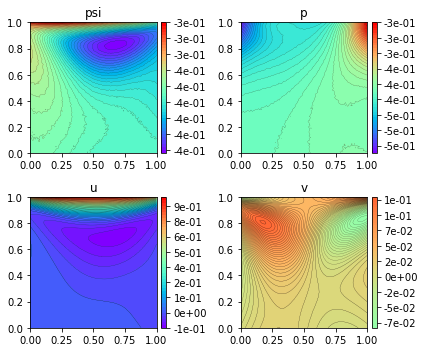

In [13]:

num_test_samples = 100




x_star = np.linspace(0, 1, num_test_samples)
y_star = np.linspace(0, 1, num_test_samples)


x_input, y_input = np.meshgrid(x_star, y_star)

xy_input = np.hstack((x_input.flatten()[:, None], y_input.flatten()[:, None]))

pt_xy_input = Variable(torch.from_numpy(xy_input).float(), requires_grad=True).to(device)
# predict (u,v,p)
u_predict,v_predict  = model.predict_uv(xy_input)
psi_predict, p_predict = model.predict_psi_p(xy_input)

#to csv
xy_uvp = torch.cat([pt_xy_input[:,0].unsqueeze(-1),pt_xy_input[:,1].unsqueeze(-1),u_predict[:,0].unsqueeze(-1),v_predict[:,0].unsqueeze(-1),p_predict[:,0].unsqueeze(-1)],1).data.cpu()

df_xy_uvp = pd.DataFrame(data=xy_uvp.detach().numpy(), columns=['x','y','u', 'v', 'p'])
df_xy_uvp.to_csv('nscavity_steady_streamfunction.csv',index=False)

psi_predict_reshape = psi_predict.data.cpu().detach().numpy().reshape(x_input.shape)
u_predict_reshape = u_predict.data.cpu().detach().numpy().reshape(x_input.shape)
v_predict_reshape = v_predict.data.cpu().detach().numpy().reshape(x_input.shape)
p_predict_reshape = p_predict.data.cpu().detach().numpy().reshape(x_input.shape)
# plot test results
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 2)
contour(gs[0, 0], x_input, y_input, psi_predict_reshape, 'psi')
contour(gs[0, 1], x_input, y_input, p_predict_reshape, 'p')
contour(gs[1, 0], x_input, y_input, u_predict_reshape, 'u')
contour(gs[1, 1], x_input, y_input, v_predict_reshape, 'v',minmaxmode=1,vmax=0.2, vmin=-0.4)
plt.tight_layout()
plt.show()

l2 error: 2.26e-01


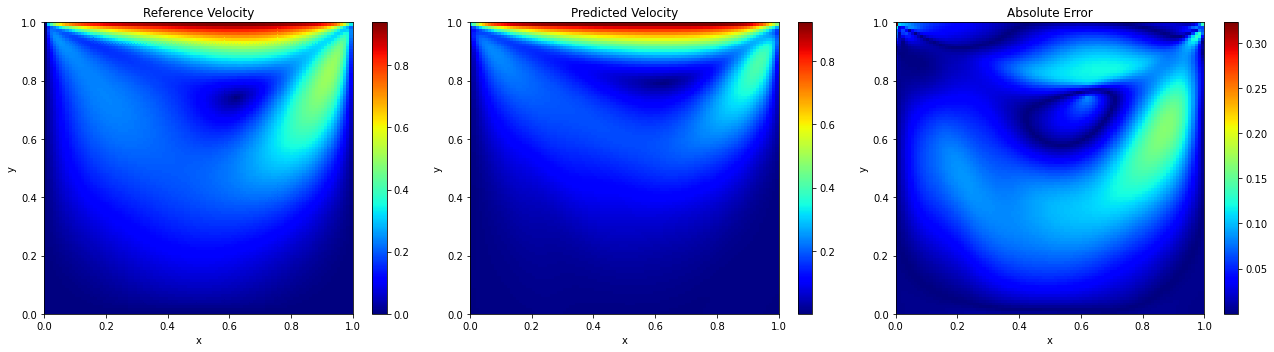

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# Test Data
nx = 100
ny = 100  # change to 100
x = np.linspace(0.0, 1, nx)
y = np.linspace(0.0, 1, ny)
X, Y = np.meshgrid(x, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predictions
u_pred, v_pred = model.predict_uv(X_star)
    
u_star = griddata(X_star, u_pred.cpu().detach().numpy().flatten(), (X, Y), method='cubic')
v_star = griddata(X_star, v_pred.cpu().detach().numpy().flatten(), (X, Y), method='cubic')

velocity = np.sqrt(u_pred.cpu().detach().numpy()**2 + v_pred.cpu().detach().numpy()**2)
velocity_star = griddata(X_star, velocity.flatten(), (X, Y), method='cubic')

#Reference    
u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
velocity_ref = np.sqrt(u_ref**2 + v_ref**2)
    
# Relative error
error = np.linalg.norm(velocity_star - velocity_ref.T, 2) / np.linalg.norm(velocity_ref, 2)
print('l2 error: {:.2e}'.format(error))
    
### Plot ###
###########
    


fig_1 = plt.figure(1, figsize=(18, 5))
fig_1.add_subplot(1, 3, 1)
plt.pcolor(X.T, Y.T, velocity_ref, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reference Velocity')

fig_1.add_subplot(1, 3, 2)
plt.pcolor(x, Y, velocity_star, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Velocity')
plt.tight_layout()
    
fig_1.add_subplot(1, 3, 3)
plt.pcolor(X, Y, np.abs(velocity_star - velocity_ref.T), cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.show()

In [ ]:
import os
PATH = os.getcwd()
torch.save(net,PATH + '\\nscavity_steady_streamfunction.pth')

In [ ]:
for k, v in net.named_parameters():
    print(v.grad)

tensor([[-0.0173,  0.0554],
        [ 0.0194, -0.0598],
        [ 0.0048, -0.0215],
        [-0.0006,  0.0010],
        [-0.0213,  0.0732],
        [ 0.0136, -0.0195],
        [-0.0099,  0.0351],
        [ 0.0012, -0.0103],
        [-0.0024, -0.0071],
        [-0.0038,  0.0073],
        [ 0.0058, -0.0124],
        [-0.0063,  0.0295],
        [ 0.0030, -0.0456],
        [ 0.0004, -0.0028],
        [ 0.0108, -0.0521],
        [ 0.0141, -0.0237],
        [-0.0148, -0.0208],
        [ 0.0011,  0.0005],
        [ 0.0133, -0.0576],
        [ 0.0125, -0.0488],
        [-0.0009, -0.0014],
        [-0.0135, -0.0204],
        [ 0.0016, -0.0135],
        [ 0.0007, -0.0031],
        [-0.0217,  0.1155],
        [-0.0098,  0.0525],
        [-0.0031,  0.0163],
        [-0.0260,  0.0748],
        [ 0.0156, -0.0543],
        [-0.0011, -0.0209],
        [-0.0038,  0.0061],
        [-0.0039,  0.0100],
        [-0.0006,  0.0026],
        [ 0.0042, -0.0050],
        [ 0.0008, -0.0004],
        [ 0.0148, -0

In [ ]:
for name, parameters in net.state_dict().items():
  if "weight" in name:
    print(parameters)

tensor([[-9.0769e-02, -2.1758e-01],
        [ 1.6814e-01,  2.7759e-01],
        [ 4.1467e-02,  2.3133e-01],
        [-1.6050e-01,  1.8161e-03],
        [-5.1915e-04, -1.3458e-01],
        [ 4.9343e-01,  3.3600e-01],
        [-7.5273e-03, -9.5159e-02],
        [-2.9848e-02, -3.9715e-01],
        [-3.6640e-01, -8.3788e-03],
        [-6.1896e-01, -3.2631e-01],
        [ 2.3001e-01,  1.4333e-01],
        [-9.6393e-03, -1.0886e-01],
        [-2.3573e-01,  7.9904e-02],
        [-1.5023e-01, -4.2175e-01],
        [-1.2914e-01,  1.0579e-01],
        [-1.8189e-01,  3.7158e-02],
        [-5.9245e-01,  3.9757e-01],
        [ 4.5185e-01, -8.4625e-02],
        [-7.3463e-02,  3.4331e-01],
        [ 3.9949e-02,  2.2057e-01],
        [ 2.0326e-01,  5.3444e-02],
        [-7.3138e-01,  4.3270e-01],
        [ 2.5148e-01,  1.9023e-01],
        [ 1.2376e-01, -9.9705e-02],
        [ 1.6050e-01, -3.7266e-01],
        [ 7.1457e-02, -2.2454e-01],
        [ 5.6165e-02, -1.6805e-01],
        [-1.7539e-01, -4.159

In [ ]:
loss

NameError: ignored